# Companion for "Intrinsic Motivation in Dynamical Control Systems" (arXiv: 2301.00005v1)

This notebook is a companion for the "A. Preliminaries" section of the article *"Intrinsic Motivation in Dynamical Control Systems"* (Tiomkin et al. 2022).

**Disclaimer:** This notebook does **not** reproduce any results from the article, nor do the authors endorse it. It is intended solely as a personal learning companion.

The estimated run time of the whole notebook is approximately 30 minutes.

In [1]:
from typing import Callable
from tqdm.notebook import tqdm

import numpy as np
from numpy.random import normal
from numpy.random import seed

import matplotlib.pyplot as plt

seed(1) # For reproducibility

### 1. Introduction

The system's dynamics are governed by an SDE.
$$
\begin{equation*}
        \mathrm{d}{X_{t}}
	=
		f\left(
			X_{t}
		\right)
		\mathrm{d}{t}
	+
		g\left( 
			X_{t}
		\right)
		\mathrm{d}{a_{t}}
	+
		\sigma^{(\mathrm{noise})}
		\mathrm{d}{W^{(\mathrm{noise})}_{t}}
\end{equation*}
$$
where
- **Dynamics:**
	- $X_{t} \in \mathcal{X} = \mathbb{R}^{d_{X}}$ is the system's state vector.
	- $f: \mathbb{R}^{d_{X}} \to \mathbb{R}^{d_{X}}$ defines the deterministic evolution of the system.
- **Agent:**
	- $a_{t} \in \mathcal{A} = \mathbb{R}^{d_{a}}$ represents the agent's actions, given by

		$$ \mathrm{d}{a_{t}} = \sigma^{(\mathrm{agent})}_{t} \mathrm{d}{W^{(\mathrm{agent})}_{t}} $$
		
		where $\sigma_{t}^{(\mathrm{agent})}$ is known as the agent's control policy.

	- $g \in \mathbb{R}^{d_{X} \times d_{a}}$ is the agent's control gain matrix that couples agent's actions to the system.
- **Environment:**
	- $W^{(\mathrm{noise})} \in \mathbb{R}^{d_{X}}$ are the (small) stochastic perturbation from the environment.
	- $\sigma^{(\mathrm{noise})}$ is considered constant.

----

We consider the simple pendulum example.
$$
\begin{equation*}
        \begin{bmatrix}
            \mathrm{d}X^{1}
        \\
			\mathrm{d}X^{2}
        \end{bmatrix}
	=
        \begin{bmatrix}
            \mathbb{d}\theta_{t}
        \\
            \mathbb{d}\dot{\theta}_{t}
        \end{bmatrix}
    =
        \begin{bmatrix}
            \dot{\theta}_{t}
            \mathbb{d}t
        \\
        -
            \sin\left( \theta_{t} \right)
            \mathbb{d}t
        +
            \mathbb{d}a_{t}
        +
            \mathbb{d}W^{(\mathrm{noise})}_{t}
        \end{bmatrix}
\end{equation*}
$$

In [2]:
class System:

    def __init__(
        self,
        state_dimension: int,
        action_dimension: int,
        environmental_noise_factor: float,
        ):

        self.state_dimension = state_dimension
        self.action_dimension = action_dimension
        self.environmental_noise_factor = environmental_noise_factor    # SEE MARKDOWN BELOW

    def state_drift(self, Xt: np.ndarray) -> np.ndarray:
        """State dynamics: drift function for the simple pendulum"""

        fXt = np.array([Xt[1], - np.sin(Xt[0])])

        return fXt

    def agent_control_gain(self, Xt: np.ndarray) -> np.ndarray:
        """Control gain: maps action to state increment for the simple pendulum"""
        
        gXt = np.array([[0], [1]])

        return gXt
    
    def environment_noise(self, sd: float) -> np.ndarray:
        """ Environmental noise for the simple pendulum"""

        dW_noise = np.array([0, normal(scale = sd)])
        env_noise = self.environmental_noise_factor * dW_noise

        return env_noise
    
    def environment_damping(self, Xt: np.ndarray):                  # SEE MARKDOWN BELOW
        """ Deterministic damping. Not implemented. """

        # env_damping = np.array([
        #     0,
        #     - self.environmental_noise_factor * np.sign(Xt[1])
        #     ])
        
        env_damping = np.array([0,0])

        return env_damping
    
class Agent:

    def __init__(self, action_dimension: int, agent_policy: Callable):
        self.action_dimension = action_dimension
        self.agent_policy = agent_policy

    def construct_action_sequence(self, times: np.ndarray) -> np.ndarray:
        """ Constructs the discretized sequence of an action path,
        given the agent's policy and a sequence of times."""

        # Standard deviation array from the agent policy.
        sigmas = np.array([self.agent_policy(t) for t in times[:-1]])                      # (n-1,)

        # Sqrt time differences (standard deviations of the Wiener processes).
        sds = np.sqrt(np.diff(times))                                                      # (n-1,)

        Wiener = normal(scale = sds[:, None], size = (len(sds), self.action_dimension))    # (n-1, da)

        # Multiply eaach row (time) by agents standard deviation.
        actions = sigmas * Wiener                                                          # (n-1, da)
        
        return actions
    
    
# GLOBAL: State and Action dimensions.
state_dimension = 2
action_dimension = 1

##### 1.1 On the system's energy

1. Final time $T$:
    - We considered $\omega = \sqrt{\frac{g}{l}} = 1$, the final time was taken to be $T = \pi$, half the period.

2. Discretization of the Numerical method $n$:
    - There is also a linear energy increase over time if the discretization is too coarse. The total number of steps was estimated for that final time $T$, requiring that the energy drift (on deterministic runs) is less than $1\%$, was $N_{T} = 400$.

3. Wiener processes:
    - By adding noise as a Wiener process, there is an energy increase over time, because its quadratic variation is not zero. I tried to add a deterministic damping, which counteracted this, but at the expense of distorting the dynamics.

    - Hence, we assume a **non-conservative energy constraint** on the agent (and similarly on the environmental noise), of the form:

    $$
    \begin{equation*}
            \int_{0}^{T}
                \sigma^{2}(t)
            \mathrm{d}t
        =
            E_{\mathrm{NC}}
        =
            cT
        \qquad
        \text{;}
    \end{equation*}
    $$
    where $c \in [0,1]$ is a stochastical noise factor. We consider.

    - We consider this energy increase small compared to the range of potential energy $\Delta U = 2$. Then
    
    $$
    \begin{equation*}
        c^{(\mathrm{noise})} << c^{(\mathrm{agent})} << \frac{\Delta U}{T} \approx 0.64
    \end{equation*}
    $$

In [3]:
DELTA_U = 2.0

# GLOBAL: Numerical method parameters.
TOTAL_TIME = np.pi
NUMERICAL_TOLERANCE = 1e-2

# GLOBAL: Noise factors.
ENVIRONMENTAL_NOISE_FACTOR = 0.01
AGENT_NOISE_FACTOR = 0.1


class EulerMaruyamaSimulator:

    def __init__(
        self,
        system: System,
        agent: Agent,
        initial_state: np.ndarray,
        total_time: float,
        total_steps: int,

        fixed_actions: np.ndarray | None = None 
        ):

        self.system = system
        self.agent = agent 
        self.initial_state = initial_state

        self.total_time = total_time
        self.total_steps = total_steps

        # Times array
        self.times = np.linspace(start = 0, stop = total_time, num = total_steps)

        # Actions array
        if fixed_actions is not None:
            self.actions = fixed_actions
        else:
            self.actions = self.agent.construct_action_sequence(self.times)

    def run_simulation(self) -> tuple[np.ndarray, np.ndarray]:

        states  = [self.initial_state.copy()]
        environmental_noises = []

        state = states[0].copy()
        previous_time: float = self.times[0]

        for k, time in enumerate(self.times[1:]):
            time: float
            time_step = time - previous_time

            # Drift increment
            state_increment_drift = self.system.state_drift(state) * time_step                      # (ds,)

            # Agent stochastic action increment
            action_increment = self.actions[k,:]                                                    # (da,)
            state_increment_action = self.system.agent_control_gain(state) @ action_increment       # (ds,)
            
            # Environment stochastic increment
            state_increment_environment = self.system.environment_noise(sd = np.sqrt(time_step))    # (ds,)

            # Environment deterministic damping
            state_increment_damping = self.system.environment_damping(state)

            # Total state increment
            state_increment = \
                + state_increment_drift \
                + state_increment_action \
                + state_increment_environment \
                + state_increment_damping
            
            state += state_increment
            states.append(state.copy())

            environmental_noises.append(state_increment_environment.copy())

            previous_time = time

        states = np.stack(states, axis = 0)
        environmental_noises = np.stack(environmental_noises, axis = 0)

        return states, environmental_noises
    
    def compute_energy(self, states) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

        potential_energy = (1 - np.cos(states[:, 0])) / DELTA_U
        kinetic_energy = 1/2 * states[:, 1]**2 / DELTA_U

        energy = potential_energy + kinetic_energy

        return energy, potential_energy, kinetic_energy

In [4]:
""" Determination of the number of steps. """

_sys = System(
    state_dimension = state_dimension,
    action_dimension = action_dimension,
    environmental_noise_factor = 0.0
)
_agt = Agent(
    action_dimension = action_dimension,
    agent_policy = lambda t: 0.0 * np.ones(shape=(action_dimension,))
)

coor_grid, vel_grid = np.meshgrid(
    np.linspace(0, +np.pi, num=50), # Initial angles
    np.array([[0,]]),               # Initial angular velocities
    indexing='ij'
    )
_initial_states = np.column_stack([coor_grid.ravel(), vel_grid.ravel()])


_total_steps_list = np.logspace(2, 4, num=20, dtype=int)

energy_drifts_per_total_steps = []
for _total_steps in tqdm(_total_steps_list, desc="Maximum Energy Drift per Total Steps"):

    energy_drifts_per_initial_state = []
    for _initial_state in tqdm(_initial_states, desc="Energy Drift per Initial State", leave=False):

        _sim = EulerMaruyamaSimulator(
            system = _sys,
            agent = _agt,
            initial_state = _initial_state,
            total_time = TOTAL_TIME,
            total_steps = _total_steps
        )
        states, _ = _sim.run_simulation()
        energy, pot, kin = _sim.compute_energy(states)

        drift = abs(energy[-1] - energy[0])
        energy_drifts_per_initial_state.append(drift)

    energy_drifts_per_total_steps.append(max(energy_drifts_per_initial_state))


Maximum Energy Drift per Total Steps:   0%|          | 0/20 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

Energy Drift per Initial State:   0%|          | 0/50 [00:00<?, ?it/s]

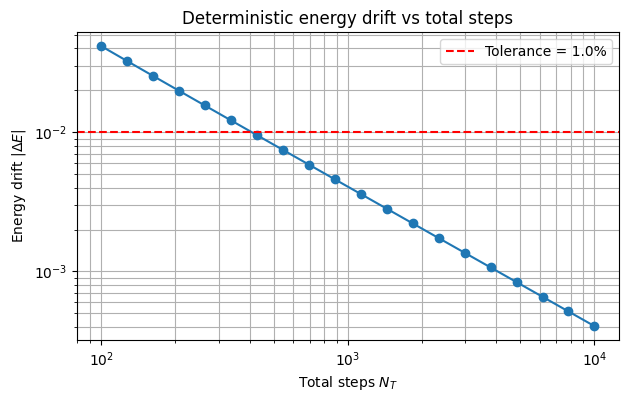

In [5]:
plt.figure(figsize=(7,4))

plt.loglog(_total_steps_list, energy_drifts_per_total_steps, marker='o')
plt.axhline(NUMERICAL_TOLERANCE, color='r', linestyle='--', label=f"Tolerance = {NUMERICAL_TOLERANCE*100:.1f}%")

plt.xlabel(r"Total steps $N_{T}$")
plt.ylabel(r"Energy drift $|\Delta E|$")
plt.title("Deterministic energy drift vs total steps")
plt.grid(True, which='both')
plt.legend()
plt.show()

##### 1.2 Single Run

After determining a reasonalbe number of steps, we proceed to realize a single run. We consider:
- **initial condition:** $X_{0} = \left( \theta_{0}, \dot{\theta}_{0} \right) = \left( \frac{\pi}{3}, 0 \right)$.
- **agent policy:** $\sigma^{(\mathrm{agent})} = 1$

In [6]:
# GLOBAL: Numerical method parameters.
TOTAL_STEPS = 400

# GLOBAL: System.
SYS = System(
    state_dimension = state_dimension,
    action_dimension = action_dimension,
    environmental_noise_factor = ENVIRONMENTAL_NOISE_FACTOR
)

# ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----
# ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----

# SEMI-GLOBAL: Initial conditions | constant agent policy / trivial agent | Euler-Maruyana Simulator.
initial_state1 = np.array([0.3*np.pi, 0.0])

agent_policy1 = lambda t: AGENT_NOISE_FACTOR * np.ones(shape=(action_dimension,))

agt1 = Agent(
    action_dimension = action_dimension,
    agent_policy = agent_policy1
)

sim1 = EulerMaruyamaSimulator(
    system = SYS,
    agent = agt1,
    initial_state = initial_state1,
    total_time = TOTAL_TIME,
    total_steps = TOTAL_STEPS,
)

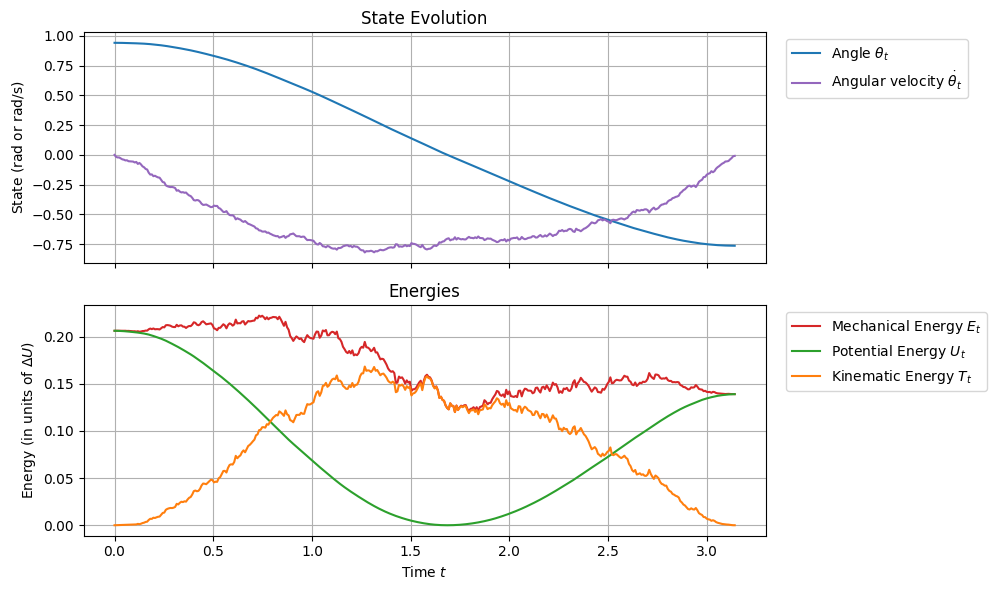

In [7]:
# Run simulation
states1, environmental_noises1 = sim1.run_simulation()
energy1, pot1, kin1 = sim1.compute_energy(states1)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(sim1.times, states1[:, 0], label=r"Angle $\theta_{t}$", color='tab:blue')
axs[0].plot(sim1.times, states1[:, 1], label=r"Angular velocity $\dot{\theta}_{t}$", color='tab:purple')
axs[0].set_ylabel(r"State ($\mathrm{rad}$ or $\mathrm{rad}/\mathrm{s}$)")
axs[0].set_title("State Evolution")
axs[0].grid(True)
axs[0].legend()
axs[0].legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

axs[1].plot(sim1.times, energy1, label=r'Mechanical Energy $E_{t}$', color='tab:red')
axs[1].plot(sim1.times, pot1, label=r'Potential Energy $U_{t}$', color='tab:green')
axs[1].plot(sim1.times, kin1, label=r'Kinematic Energy $T_{t}$', color='tab:orange')
axs[1].set_xlabel(r"Time $t$")
axs[1].set_ylabel(r"Energy (in units of $\Delta U$)")
axs[1].set_title("Energies")
axs[1].grid(True)
axs[1].legend()
axs[1].legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))

plt.tight_layout()
plt.show()

### 2. Mutual Information Maximization for given initial state

*Since the initial state $X_{0}$ is given and is not actually a random variable, it will be omitted. Everything depends on it, in the same way it depends on $T$.*


The mutual information $I$ between $X_{T}$ and $A$ is given by
$$
\begin{equation*}
		I\left(
			X_{T}; A
		\right)
	=
		H\left(
			X_{T}
		\right)
	-
		H\left(
			X_{T}
		\mid
			A
		\right)
\end{equation*}
$$

The entropy $H$ for a random variable $X$ is given by
$$
\begin{equation*}
		H\left(
			X
		\right)
	=
		\mathbb{E}_{p_{X}}\left[
			\log\left(
				\frac{1}{
					p_{X}\left(
						X
					\right)
				}
			\right)
		\right]
\end{equation*}
$$


**Note:** Entropies are computed using Monte Carlo sampling rather than a grid-based method. That is, computing the arithmetical mean over samples drawn from a distribution $p$, rather than multiplying by $p(x)$ over a regular grid in the alphabet space.


In this section, 4 numerical-simulation parameters are defined:
- the number of single runs (given action path) S_RUNS
- the number of bandwidths considered N_BW and cross validations N_CV for the KDE density estimation
- the number of action paths (given an agent's policy) A_RUNS

Finding the optimal parameters would take more time, so the following results should be seen as exploratory.
- Section 2.1 addresses the first three: S_RUNS, N_BW and N_CV.
- Section 2.2 addresses the last one: A_RUNS

In [8]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

class MutualInformationEstimator:

    def __init__(
        self,
        system: System,
        agent: Agent,
        initial_state: np.ndarray,
        total_time: float,
        total_steps: int,
        s_runs: int,
        a_runs: int,
        ):

        self.system = system
        self.agent = agent

        self.initial_state = initial_state
        self.total_time = total_time
        self.total_steps = total_steps
        
        self.s_runs = s_runs
        self.a_runs = a_runs

    def _estimate_kde(
        self,
        samples: np.ndarray,
        n_bw: int = 10,
        n_cv: int = 3
        ) -> tuple[KernelDensity, np.ndarray]:
        """
        Fit a KernelDensity estimator with optional bandwidth search.
        X: (N, d) array of samples
        """

        bw_min = np.std(samples) * 0.1
        bw_max = np.std(samples) * 2
        bandwidths = np.logspace(np.log10(bw_min), np.log10(bw_max), n_bw)

        grid = GridSearchCV(
            KernelDensity(kernel='gaussian'),
            {'bandwidth': bandwidths},
            cv=n_cv
            )
                
        grid.fit(samples)
        kde = grid.best_estimator_

        return kde, samples

    def _compute_entropy(self, kde: KernelDensity, samples: np.ndarray) -> float:

        log_probs = kde.score_samples(samples)
        entropy = - float(np.mean(log_probs))

        return entropy

    def _run_fixed_action(
        self,
        passed_actions: np.ndarray | None = None
        ) -> tuple[np.ndarray, np.ndarray]:

        _sim = EulerMaruyamaSimulator(
            system = self.system,
            agent = self.agent,
            initial_state = self.initial_state,
            total_time = self.total_time,
            total_steps = self.total_steps,
            fixed_actions = passed_actions
        )

        final_states = []
        sbar = tqdm(range(self.s_runs), desc="Simulations per action path", leave= False)
        for _ in sbar:
            states, _ = _sim.run_simulation()
            final_state = states[-1, :]
            final_states.append(final_state)

        final_states = np.stack(final_states, axis = 0)     # (s_runs, ds)
        times = _sim.times
        
        return final_states, times

    def _estimate_conditional_entropy_fixed_action(
        self,
        passed_actions: np.ndarray | None = None
        ) -> tuple[float, np.ndarray, np.ndarray]:

        final_states, times = self._run_fixed_action(passed_actions)
        kde, samples = self._estimate_kde(final_states)
        entropy = self._compute_entropy(kde, samples)

        return entropy, final_states, times

    def _estimate_conditional_entropy(self):

        all_final_states = []
        entropies = []
        abar = tqdm(range(self.a_runs), desc="Entropy per action policy", leave= False)
        for _ in abar:
            entropy, final_states, _ = self._estimate_conditional_entropy_fixed_action()

            entropies.append(entropy)
            all_final_states.append(final_states.copy())

        conditional_entropy = float(np.mean(entropies))
        all_final_states = np.stack(all_final_states, axis = 0)     # (a_runs, s_runs, ds) or (a_runs, s_runs) if ds = 1
        # Ensure shape (a_runs, s_runs, ds)
        if all_final_states.ndim == 2:
            all_final_states = all_final_states[:, :, None]
        all_final_states_flat = all_final_states.reshape((self.a_runs * self.s_runs, -1))

        return conditional_entropy, all_final_states_flat
    
    def _estimate_marginal_entropy(self, all_final_states_flat: np.ndarray) -> float:

        kde, samples = self._estimate_kde(all_final_states_flat)
        marginal_entropy = self._compute_entropy(kde, samples)

        return marginal_entropy

    def compute_mutual_information(self) -> tuple[float, float, float]:

        conditional_entropy, all_final_states_flat = self._estimate_conditional_entropy()
        marginal_entropy = self._estimate_marginal_entropy(all_final_states_flat)

        mutual_information = marginal_entropy - conditional_entropy

        return mutual_information, conditional_entropy, marginal_entropy

##### 2.1 Estimation of s_runs (and n_bw, n_cv)

Due to the fact that the variations in the space of these parameters was an order of magnitude (in nats) less significant that for the one in section 2.2, they were chosen as reasonably lowest as they could.

- S_RUNS = 5    # SEE BELOW
- N_BW = 10, N_CV = 3 (set in the defaults of the MutualInformationEstimator._estimate_kde method).

In [9]:
# 1. Generate an action path
_sim = EulerMaruyamaSimulator(
    system = SYS,
    agent = agt1,
    initial_state = initial_state1,
    total_time = TOTAL_TIME,
    total_steps = TOTAL_STEPS,
)
_action_path = _sim.actions

In [10]:
# 2. Entropies vs (s_runs, n_bw, m_cv)

entropies_per_s_runs = []
s_runs_list = np.linspace(5, 15, 10, dtype=int)
for s_runs in tqdm(s_runs_list, desc="Entropy per s_runs",leave=False):

    samples = []
    for i in range(10): # to estimate variance
        _mie = MutualInformationEstimator(
            system = SYS,
            agent = agt1,
            initial_state = initial_state1,
            total_time = TOTAL_TIME,
            total_steps = TOTAL_STEPS,
            s_runs = s_runs,
            a_runs = 1
        )

        final_states, _ = _mie._run_fixed_action(_action_path)
        kde, _ = _mie._estimate_kde(final_states, n_bw = 10, n_cv = 5)
        entropy = _mie._compute_entropy(kde, final_states)
        samples.append(entropy)

    entropies_per_s_runs.append(samples)

entropies_per_s_runs = np.array(entropies_per_s_runs)

entropy_means = entropies_per_s_runs.mean(axis=1)
entropy_stds = entropies_per_s_runs.std(axis=1)

Entropy per s_runs:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/6 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/8 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/10 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/12 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/15 [00:00<?, ?it/s]

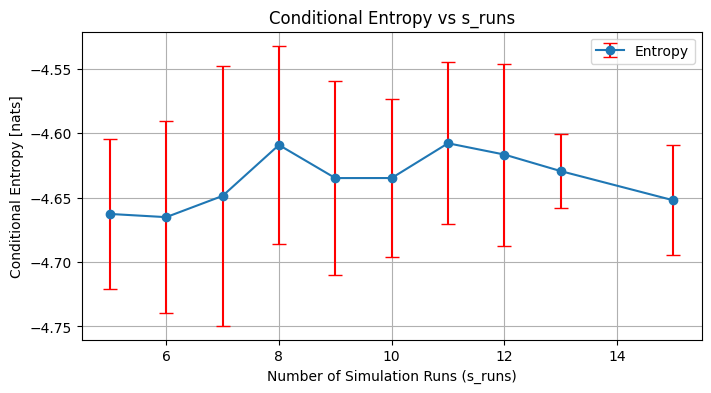

In [11]:
plt.figure(figsize=(8,4))
plt.errorbar(s_runs_list, entropy_means, yerr=entropy_stds, fmt='o-', capsize=5, ecolor='r', label='Entropy')
plt.xlabel("Number of Simulation Runs (s_runs)")
plt.ylabel("Conditional Entropy [nats]")
plt.title("Conditional Entropy vs s_runs")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# GLOBAL: Monte Carlo parameters (1/2)
S_RUNS = 5

##### Ploting a KDE to verify

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

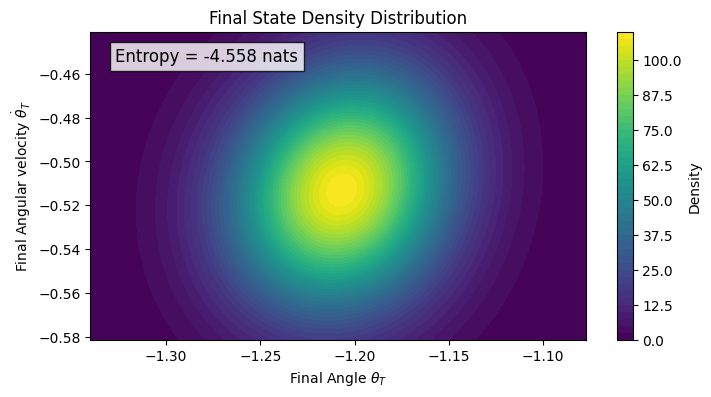

In [13]:
def make_kde_grid(samples, n_points, margin_factor):
    """
    Create a grid covering all dimensions of the samples, with optional margin.
    
    Args:
        samples: array of shape (n_samples, n_dims)
        n_points: number of points per axis
        margin_factor: fraction of range to extend beyond min/max
    
    Returns:
        grid_points: (n_points**n_dims, n_dims) array of all grid points
        mesh: list of n_dims mesh arrays (for reshaping back)
    """

    n_dims = samples.shape[1]
    axes = []
    for d in range(n_dims):
        min_val, max_val = samples[:,d].min(), samples[:,d].max()
        margin = margin_factor * (max_val - min_val)
        axes.append(np.linspace(min_val - margin, max_val + margin, n_points))
    
    mesh = np.meshgrid(*axes, indexing='ij')
    grid_points = np.stack([m.ravel() for m in mesh], axis=-1)
    
    return grid_points, mesh

# ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----
# ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ---- ----

_mie_kde_plot = MutualInformationEstimator(
    system = SYS,
    agent = agt1,
    initial_state = initial_state1,
    total_time = TOTAL_TIME,
    total_steps = TOTAL_STEPS,
    s_runs = S_RUNS,
    a_runs = 1
)

final_states, _ = _mie_kde_plot._run_fixed_action(passed_actions=_action_path)
kde, _ = _mie_kde_plot._estimate_kde(final_states)

grid_points, mesh = make_kde_grid(final_states, n_points = 100, margin_factor = 2)
Z = np.exp(kde.score_samples(grid_points))
Z_mesh = Z.reshape([len(a) for a in mesh])

plt.figure(figsize=(8,4))

plt.contourf(mesh[0], mesh[1], Z_mesh, levels=50, cmap='viridis')
plt.xlabel(r"Final Angle $\theta_{T}$")
plt.ylabel(r"Final Angular velocity $\dot{\theta}_{T}$")
plt.colorbar(label="Density")

entropy = _mie_kde_plot._compute_entropy(kde, final_states)
plt.text(
    0.05, 0.95, f"Entropy = {entropy:.3f} nats", 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top', 
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)


plt.title("Final State Density Distribution")
plt.show()



##### 2.2 Estimation of a_runs

The number of runs per agent policy was set to 17, chosen to be as high as possible while keeping computation time reasonable. Exploration with multiple runs showed that lower values could led to higher variance. Ultimately, however, this choice remains arbitrary.

In [14]:
mi_per_a_runs = []
a_runs_list = np.linspace(1, 20, 10, dtype=int)

for a_runs in tqdm(a_runs_list, desc="Mutual Information per a_runs", leave=False):

    samples = []
    for i in range(5):  # to estimate variance
        _mie = MutualInformationEstimator(
            system=SYS,
            agent=agt1,
            initial_state=initial_state1,
            total_time=TOTAL_TIME,
            total_steps=TOTAL_STEPS,
            s_runs=S_RUNS,
            a_runs=a_runs
        )

        mutual_information, conditional_entropy, marginal_entropy = _mie.compute_mutual_information()
        samples.append([mutual_information, conditional_entropy, marginal_entropy])

    samples = np.array(samples)
    mi_per_a_runs.append(samples)

mi_per_a_runs = np.array(mi_per_a_runs)

means = mi_per_a_runs.mean(axis=1)
stds  = mi_per_a_runs.std(axis=1)

Mutual Information per a_runs:   0%|          | 0/10 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/1 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/1 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/1 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/1 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/1 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/3 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/3 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/3 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/3 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/3 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/7 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/9 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/11 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/13 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/15 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/20 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/20 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/20 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/20 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/20 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

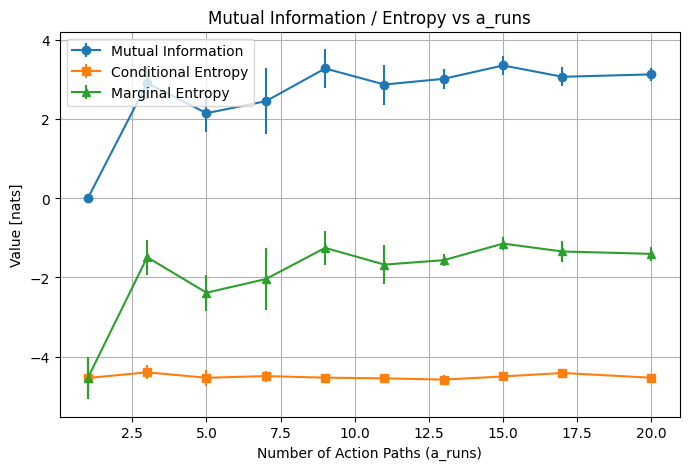

In [15]:
plt.figure(figsize=(8,5))
plt.errorbar(a_runs_list, means[:,0], yerr=stds[:,0], fmt='-o', label="Mutual Information")
plt.errorbar(a_runs_list, means[:,1], yerr=stds[:,1], fmt='-s', label="Conditional Entropy")
plt.errorbar(a_runs_list, means[:,2], yerr=stds[:,2], fmt='-^', label="Marginal Entropy")
plt.xlabel("Number of Action Paths (a_runs)")
plt.ylabel("Value [nats]")
plt.title("Mutual Information / Entropy vs a_runs")
plt.legend()
plt.grid(True)
plt.show()

In [16]:
A_RUNS = 17

mie1 = MutualInformationEstimator(
    system = SYS,
    agent = agt1,
    initial_state = initial_state1,
    total_time = TOTAL_TIME,
    total_steps = TOTAL_STEPS,
    s_runs = S_RUNS,
    a_runs = A_RUNS
)

### 3. Empowerment (Channel Capacity): Maximization of Mutual Information Maximization over action policies

The empowerment (channel capacity) $\mathcal{C}$ is defined as the maximum, over all probability distributions for $A$, of the mutual information between $X_{T}$ and $A$.
$$
\begin{equation*}
		\mathcal{C}
	\coloneqq
		\max_{
			p_{A}
		}
			\big\{
				I\left(
					X_{T}; A
				\right)
			\big\}
\end{equation*}
$$

In [17]:
class ChannelCapacityEstimator:

    def __init__(
        self,
        system: System,
        initial_state: np.ndarray,
        total_time: float,
        total_steps: int,
        s_runs: int,
        a_runs: int,
        agent_policies: list[Callable]
        ):

        self.system = system
        self.initial_state = initial_state
        self.total_time = total_time
        self.total_steps = total_steps
        self.s_runs = s_runs
        self.a_runs = a_runs

        self.agent_policies = agent_policies
    
    def estimate_channel_capacity(self) -> tuple[float, Callable]:

        mutual_informations: list[float] = []
        agent_policies: list[Callable] = []
        ap_bar = tqdm(self.agent_policies, desc="Empowerment per initial state", leave= False)
        for agent_policy in ap_bar:
                        
            agent = Agent(
                action_dimension = self.system.action_dimension,
                agent_policy = agent_policy
            )

            mie = MutualInformationEstimator(
                system = self.system,
                agent = agent,
                initial_state = self.initial_state,
                total_time = self.total_time,
                total_steps = self.total_steps,
                s_runs = self.s_runs,
                a_runs = self.a_runs
            )

            mutual_information, _, _ = mie.compute_mutual_information()
            mutual_informations.append(mutual_information)
            agent_policies.append(agent_policy)

        argmax_idx = np.argmax(mutual_informations)
        channel_capacity = mutual_informations[argmax_idx]
        argmax = agent_policies[argmax_idx]

        return channel_capacity, argmax

##### 3.1 Agent's Policies

##### 3.1.1 Family of Policies

**Note:** The maximization was not done over the infinite-dimensional space of all action policies, but just over an extremely reduced subset given by:
$$
\begin{equation*}
		\sigma^{(\mathrm{agent})}(t)
	=
		c^{(\mathrm{agent})} \cdot
		\frac{\omega}{4}
		\big[
			2\omega T
		+
			\sin\left(
				2\phi
			\right)
		-
			\sin\left(
				2
				\left(
					\omega T + \phi
				\right)
			\right)
		\big]
		\big\lvert
			\sin\left(
				\omega t + \phi
			\right)
		\big\rvert
\end{equation*}
$$

In [18]:
def sigma_trig_family(T: float, w: float, p: float) -> Callable:
    normalization_factor = 1/4*w * (2*w*T + np.sin(2*p) - np.sin(2*(w*T + p)))
    sigma = lambda t: \
        AGENT_NOISE_FACTOR * \
        normalization_factor * \
        np.abs(np.sin(w*t+p)) * \
        np.ones(shape=(action_dimension,))
    return sigma

We consider
- $\omega_{\mathrm{max}} = 3$ (greater than the natural frequency of the system) and
- $\phi = 0$.

##### 3.1.2 Estimation of number of policies

In [19]:
n_policies_list = range(1, 10)
channel_capacities = []
for n_policies in tqdm(n_policies_list, desc="n_polices", leave=False):

    samples = []
    for i in range(5):

        _cce = ChannelCapacityEstimator(
            system = SYS,
            initial_state = initial_state1,
            total_time = TOTAL_TIME,
            total_steps = TOTAL_STEPS,
            s_runs = S_RUNS,
            a_runs = A_RUNS,
            agent_policies = [sigma_trig_family(TOTAL_TIME, w, 0) for w in np.linspace(start=0, stop=3, num=n_policies)]
        )

        cc, _ = _cce.estimate_channel_capacity()
        samples.append(cc)

    channel_capacities.append(samples)

channel_capacities = np.array(channel_capacities)

# Compute mean and standard deviation along the samples axis
cc_means = channel_capacities.mean(axis=1)
cc_stds = channel_capacities.std(axis=1)

n_polices:   0%|          | 0/9 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/1 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/1 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/1 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/1 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/1 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/3 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/3 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/3 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/3 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/3 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/4 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/4 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/4 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/4 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/4 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/6 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/6 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/6 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/6 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/6 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/7 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/7 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/7 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/7 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/7 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/8 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/8 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/8 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/8 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/8 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/9 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/9 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/9 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/9 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/9 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

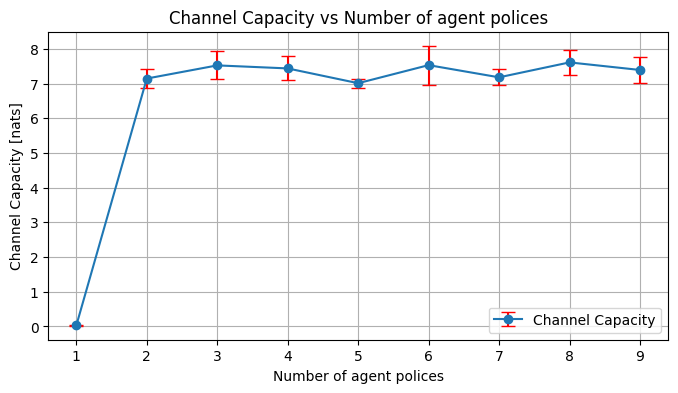

In [20]:
plt.figure(figsize=(8,4))
plt.errorbar(range(1, 10), cc_means, yerr=cc_stds, fmt='o-', capsize=5, ecolor='r', label='Channel Capacity')
plt.xlabel("Number of agent polices")
plt.ylabel("Channel Capacity [nats]")
plt.title("Channel Capacity vs Number of agent polices")
plt.grid(True)
plt.legend()
plt.show()

There is no good reason to choose a number higher than 2.

In [21]:
# GLOBAL: Agent policies.
NUMBER_OF_AGENT_POLICES = 2
TRIG_AGENT_POLICES = [
    sigma_trig_family(TOTAL_TIME, w, 0) for w in np.linspace(start=0, stop=3, num=NUMBER_OF_AGENT_POLICES)
]

### 4. Empowerment maximization over initial states

To determine which initials states grant more control to the agent, we consider a sweep over:
- $X^{1} = \theta \in (0, \pi)$ with
- $X^{2} = \dot{\theta} = 0$

In [22]:
# GLOBAL: Initial states.
N_STATES = 50
coor_grid, vel_grid = np.meshgrid(
    np.linspace(0, +np.pi, N_STATES),   # Initial angles
    np.array([[0,]]),                   # Initial angular velocities
    indexing='ij'
    )
INITIAL_STATES = np.column_stack([coor_grid.ravel(), vel_grid.ravel()])

channel_capacities = []
cc_bar = tqdm(INITIAL_STATES, desc = "Empowerment over initial states", leave=False)
for initial_state in cc_bar:
    cce = ChannelCapacityEstimator(
        system = SYS,
        initial_state = initial_state,
        total_time = TOTAL_TIME,
        total_steps = TOTAL_STEPS,
        s_runs = S_RUNS,
        a_runs = A_RUNS,
        agent_policies = TRIG_AGENT_POLICES
    )
    channel_capacity = cce.estimate_channel_capacity()
    channel_capacities.append(channel_capacity)

Empowerment over initial states:   0%|          | 0/50 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Empowerment per initial state:   0%|          | 0/2 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Entropy per action policy:   0%|          | 0/17 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

Simulations per action path:   0%|          | 0/5 [00:00<?, ?it/s]

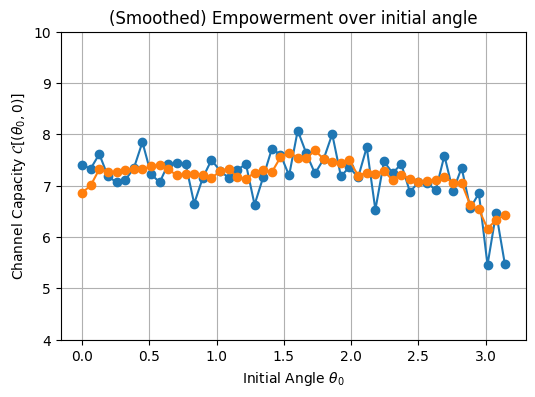

In [23]:
from scipy.ndimage import convolve1d

_initial_angles = np.linspace(0, + np.pi, N_STATES)
ccs = [cc for cc, _ in channel_capacities]

# Smoothing (periodically, using the symmetry of the system)
_n_kernel = int(N_STATES * 0.1)
kernel = np.ones(_n_kernel)/_n_kernel
ccs_periodic = np.concatenate([ccs[::-1], ccs]) # Flip and append
smoothed = convolve1d(ccs, kernel, mode='wrap')

plt.figure(figsize=(6,4))
plt.plot(_initial_angles, ccs, '-o')
plt.plot(_initial_angles, smoothed, '-o')

plt.xlabel(r"Initial Angle $\theta_{0}$")
plt.ylabel(r"Channel Capacity $\mathcal{C}[(\theta_{0}, 0)]$")
plt.ylim(4, 10)
plt.title("(Smoothed) Empowerment over initial angle")
plt.grid(True)
plt.show()

### 6. Discussion

- It made sense to progress to this stage, as this is the first result that can be physically interpreted. I hadn’t anticipated that it would become so computationally demanding.
- The result differs from the one expected (minimum for $\theta_{0} = 0$ and maximum for $\theta_{0} = \pi$).
- Several aspects require further exploration, such as
    - alternative time windows,
    - initial conditions (including velocities),
    - stochastic factors, and
    - agent policies.
    
    However, the most fundamental task is to refine the numerical parameters defined in Section 2, which will only be feasible once the code is optimized.



----

Until resolved, there is little reason to proceed with initial state gradient-ascent optimization or the subsequent "on-the-fly" empowerment maximization. The latter would consist of:

### 7. "On-the-fly" empowerment maximization

Let $t$ be current time and $T = t + \Delta t'$ a future time.
1. **Choose an action path** $\left( a \right)_{t}^{T}$.
2. **Compute the empowerment of the chosen action path:**
    - Get distribution of final states: Simulate the SDE multiple times due to environment noise
    - Considering each of those final states as an initial state of a future process, compute the empowerments and, finally, average them over the environmental noise.
3. **Maximize over various action paths.**
$$
\begin{equation*}
		J[a]
	=
		\mathbb{E}_{\text{noise}}\bigg[
			\mathcal{C}\Big(
				f\left( x_{t} \right)
            +
                g\left( x_{t} \right)
                a
                \Delta t'
            +
                {\eta}_{t + \Delta t'}
            \Big)
		\bigg]
	\iff
		a^{\ast}
	=
		\argmax_{a \in \mathcal{A}}
			J[a]
\end{equation*}
$$
